In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import requests, bs4
import sys

if sys.version_info[0] == 3:

    from urllib.request import urlopen

else:

    from urllib import urlopen
from urllib.parse import urlencode, quote_plus, unquote


In [3]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element, dump, ElementTree

In [4]:
import datetime as dt

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
fileName = '/content/drive/MyDrive/미세먼지 데이터/forecast_2020.csv'
#데이터 불러오기
data = pd.read_csv(fileName)
#weather_data = data[['temp', 'rain', 'wind', 'wind_dir', 'hum', 'press', 'cloud', 'temp_ground', 'no2', 'co', 'so2']].to_numpy() #input data는 바뀔 수 있다.
weather_data = data[['temp', 'rain', 'wind', 'wind_dir', 'hum', 'cloud', 'no2', 'co', 'so2']].to_numpy()
for i in range(len(weather_data)): #기상청에서 제공하는 API의 전운량에 따른 하늘 상태 분류 기준에 맞춰 데이터 가공
  if(weather_data[i, 5] < 6):
    weather_data[i, 5] = 1
  elif(weather_data[i, 5] < 9):
    weather_data[i, 5] = 3
  else:
    weather_data[i, 5] = 4

pm_data = data[['pm10']].to_numpy()
np.set_printoptions(suppress = True)
print(weather_data)
print(weather_data.shape)
print(pm_data)
print(pm_data.shape)

[[ 1.4    0.     1.4   ...  0.042  0.9    0.011]
 [ 0.9    0.     2.8   ...  0.043  1.     0.012]
 [ 0.6    0.     2.    ...  0.045  1.     0.012]
 ...
 [-7.2    0.     2.7   ...  0.031  0.5    0.003]
 [-7.4    0.     2.5   ...  0.027  0.5    0.003]
 [-7.6    0.     2.2   ...  0.022  0.5    0.003]]
(48591, 9)
[[153.]
 [159.]
 [140.]
 ...
 [ 37.]
 [ 37.]
 [ 38.]]
(48591, 1)


In [6]:
#미세먼지 수치에 따라 좋음, 보통, 나쁨, 매우 나쁨(각각 0,1,2,3)으로 분류
def conversion(pm_data): 
  pm_target = []
  for i in range(len(pm_data)):
    if(pm_data[i]<=30):
      pm_target.append(0)
      continue
    if(pm_data[i]<=80):
      pm_target.append(1)
      continue
    if(pm_data[i]<=150):
      pm_target.append(2)
      continue
    pm_target.append(3)
  return np.array(pm_target)

#numpy 배열로 변환 후 하나의 열 가진 배열로 변환
pm_target = np.array(conversion(pm_data))
pm_target = np.reshape(pm_target, (-1,1))
print(pm_target)
print(pm_target.shape)

[[3]
 [3]
 [2]
 ...
 [1]
 [1]
 [1]]
(48591, 1)


In [ ]:
def build_model():
  model = keras.Sequential([layers.Dense(200, activation='relu', input_shape=(10,)),
                            layers.Dropout(0.3),
                            layers.Dense(200, activation= 'relu'),
                            layers.Dropout(0.3),
                            layers.Dense(4, activation = 'softmax')
                            ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics='accuracy')
  return model

model = build_model()
history = model.fit(train_scaled, train_target, epochs=26,
                    validation_data = (val_scaled, val_target), verbose = 0, callbacks = [PrintDot()])

In [9]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 1000

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_input, val_input, train_target, val_target = train_test_split(weather_data, pm_data, test_size = 0.1, random_state = 42)

ss = StandardScaler()
ss.fit(train_input)

train_scaled = ss.transform(train_input)
train_scaled = np.reshape(train_scaled, (train_scaled.shape[0], train_scaled.shape[1], 1)) #CNN-LSTM에 input으로 넣기 위해 3차원으로 모양 바꿈
train_classified_target = conversion(train_target) #분류된 타겟

val_scaled = ss.transform(val_input)
val_scaled = np.reshape(val_scaled, (val_scaled.shape[0], val_scaled.shape[1], 1))
val_classified_target = conversion(val_target)
print(train_scaled.shape)
print(val_scaled.shape)

(43731, 9, 1)
(4860, 9, 1)


In [11]:
def build_CNN_LSTM_classifier_model():
  cnn = keras.Sequential()
  cnn.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu', padding = 'same', input_shape = (9, 1))) #input data 인자의 개수가 바뀌면 수정해줘야 함
  cnn.add(layers.MaxPooling1D(pool_size=(2)))
  cnn.add(layers.Dropout(0.3))
  
  model = keras.Sequential()
  model.add(cnn)
  model.add(layers.LSTM(128, return_sequences = True))
  model.add(layers.Dropout(0.3))
  model.add(layers.LSTM(128, return_sequences = True))
  model.add(layers.Dropout(0.3))
  model.add(layers.LSTM(128, return_sequences = False))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(4, activation = 'softmax'))
  model.compile(loss='sparse_categorical_crossentropy', metrics = ['accuracy'])
  return model

model = build_CNN_LSTM_classifier_model()



early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

history = model.fit(train_scaled, train_classified_target, epochs=50,
                    validation_data = (val_scaled, val_classified_target), verbose = 0, callbacks = [PrintDot()])


..................................................

In [ ]:
def build_CNN_LSTM_Regression_model():
  cnn = keras.Sequential()
  cnn.add(layers.Conv1D(filters = 32, kernel_size = 3, activation='relu', input_shape = (9,1)))
  cnn.add(layers.MaxPooling1D(pool_size=2))
  cnn.add(layers.Dropout(0.3))

  model = keras.Sequential()
  model.add(cnn)
  model.add(layers.LSTM(128, input_shape = (9, 1), return_sequences = True))
  model.add(layers.Dropout(0.3))
  model.add(layers.LSTM(128, return_sequences = True))
  model.add(layers.Dropout(0.3))
  model.add(layers.LSTM(128, return_sequences = False))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(1))
  model.compile(loss='mean_squared_error', metrics = ['mse'])
  return model

model = build_CNN_LSTM_Regression_model()



early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)

history = model.fit(train_scaled, train_target, epochs=50,
                    validation_data = (val_scaled, val_target), verbose = 0, callbacks = [PrintDot()])


..................................................

152/152 [==============================] - 1s 7ms/step - loss: 0.6350 - accuracy: 0.7222
0
0


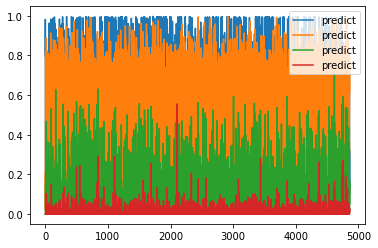

In [ ]:
model.evaluate(val_scaled, val_classified_target)
predictions = model.predict(val_scaled)
print(np.argmax(predictions[0]))
print(val_classified_target[0])
plt.plot(model.predict(val_scaled), label = 'predict')
plt.legend()
plt.show()


In [ ]:
model.evaluate(val_scaled, val_target)
predictions = model.predict(val_scaled)
print(np.argmax(predictions[0]))
print(val_target[0])
plt.plot(predictions, label = 'predict')
plt.legend()
plt.show()

304/304 [==============================] - 2s 6ms/step - loss: 0.6481 - accuracy: 0.7220


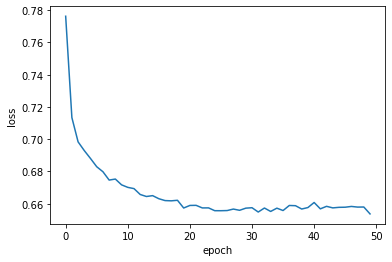

In [ ]:
model.evaluate(val_scaled, val_classified_target)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [ ]:
KST = dt.timezone(dt.timedelta(hours=9))
date = dt.datetime.now(tz =KST)
base_date = date.strftime("%Y%m%d")
hour = int(date.strftime("%H"))
minute = int(date.strftime("%M"))
if(minute < 45): # API제공 시간이 시각마다 45분부터이므로 45분 전이라면 시간 - 1
  hour-=1
hour = f"{hour:0>2}"
minute = f"{minute:0>2}"
base_time = hour+minute
print(base_date, base_time)

20211123 1119


In [ ]:
url = "http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getUltraSrtFcst"
my_API_key = unquote('cBn6gi4qKDLBlWB%2Bgbi8oMmvSfuLJiB0AB17c%2FGTkYt3ANSA51kBQ4RaRConOzij%2BID0X7VQbSRtcLGDcwGY9g%3D%3D')
queryParams = '?' + urlencode(    # get 방식으로 쿼리를 분리하기 위해 '?'를 넣은 것이다. 메타코드 아님.
    {
        quote_plus('ServiceKey') : my_API_key,
        quote_plus('numOfRows') : '100', 
        quote_plus('pageNo') : '1',
        quote_plus('base_date') : base_date,
        quote_plus('base_time') : base_time,
        quote_plus('nx') : '60',
        quote_plus('ny') : '127'
     }
)
response = requests.get(url + queryParams).text.encode('utf-8')
print(response)
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
rows = xmlobj.findAll('item')

b'<?xml version="1.0" encoding="UTF-8"?>\r\n<response><header><resultCode>00</resultCode><resultMsg>NORMAL_SERVICE</resultMsg></header><body><dataType>XML</dataType><items><item><baseDate>20211123</baseDate><baseTime>1130</baseTime><category>LGT</category><fcstDate>20211123</fcstDate><fcstTime>1200</fcstTime><fcstValue>0</fcstValue><nx>60</nx><ny>127</ny></item><item><baseDate>20211123</baseDate><baseTime>1130</baseTime><category>LGT</category><fcstDate>20211123</fcstDate><fcstTime>1300</fcstTime><fcstValue>0</fcstValue><nx>60</nx><ny>127</ny></item><item><baseDate>20211123</baseDate><baseTime>1130</baseTime><category>LGT</category><fcstDate>20211123</fcstDate><fcstTime>1400</fcstTime><fcstValue>0</fcstValue><nx>60</nx><ny>127</ny></item><item><baseDate>20211123</baseDate><baseTime>1130</baseTime><category>LGT</category><fcstDate>20211123</fcstDate><fcstTime>1500</fcstTime><fcstValue>0</fcstValue><nx>60</nx><ny>127</ny></item><item><baseDate>20211123</baseDate><baseTime>1130</baseTime>

In [ ]:
rowList = []
nameList = []
columnList = []

rowsLen = len(rows)
for i in range(0, rowsLen):
    columns = rows[i].find_all()
    
    columnsLen = len(columns)
    for j in range(0, columnsLen):
        # 첫 번째 행 데이터 값 수집 시에만 컬럼 값을 저장한다. (어차피 rows[0], rows[1], ... 모두 컬럼헤더는 동일한 값을 가지기 때문에 매번 반복할 필요가 없다.)
        if i == 0:
            nameList.append(columns[j].name)
        # 컬럼값은 모든 행의 값을 저장해야한다.    
        eachColumn = columns[j].text
        columnList.append(eachColumn)
    rowList.append(columnList)
    columnList = []    # 다음 row의 값을 넣기 위해 비워준다. (매우 중요!!)
    
result = pd.DataFrame(rowList, columns=nameList)
result_sortedby_time = result.sort_values(by = ['category', 'fcstDate', 'fcstTime']) # 카테고리(input 데이터 인자의 종류), 예보 시간 순으로 정렬
str_expr = "(category == 'T1H') or (category == 'RN1') or (category == 'SKY') or (category == 'REH') or (category == 'VEC') or (category == 'WSD')"
selected_result = result_sortedby_time.query(str_expr)
selected_result.loc[selected_result['fcstValue'] == '1.0mm 미만', 'fcstValue'] = 0 # df.loc으로 fcstValue가 1mm 미만이라면 0으로 수정
selected_result.loc[selected_result['fcstValue'] == '1.0mm', 'fcstValue'] = 1
print(selected_result)

t1h = []
rn1 = []
sky = []
reh = []
vec = []
wsd = []
t1h = selected_result[selected_result['category'] == 'T1H']
rn1 = selected_result[selected_result['category'] == 'RN1']
sky = selected_result[selected_result['category'] == 'SKY']
reh = selected_result[selected_result['category'] == 'REH']
vec = selected_result[selected_result['category'] == 'VEC']
wsd = selected_result[selected_result['category'] == 'WSD']

t1h = t1h[['fcstValue']]
rn1 = rn1[['fcstValue']]
sky = sky[['fcstValue']]
reh = reh[['fcstValue']]
vec = vec[['fcstValue']]
wsd = wsd[['fcstValue']]

t1h = np.array(t1h).astype(np.float)
rn1 = np.array(rn1).astype(np.float)
sky = np.array(sky).astype(np.float)
reh = np.array(reh).astype(np.float)
vec = np.array(vec).astype(np.float)
wsd = np.array(wsd).astype(np.float)

    baseDate baseTime category  fcstDate fcstTime fcstValue  nx   ny
30  20211123     1130      REH  20211123     1200        45  60  127
31  20211123     1130      REH  20211123     1300        40  60  127
32  20211123     1130      REH  20211123     1400        45  60  127
33  20211123     1130      REH  20211123     1500        45  60  127
34  20211123     1130      REH  20211123     1600        55  60  127
35  20211123     1130      REH  20211123     1700        55  60  127
12  20211123     1130      RN1  20211123     1200         0  60  127
13  20211123     1130      RN1  20211123     1300         0  60  127
14  20211123     1130      RN1  20211123     1400         0  60  127
15  20211123     1130      RN1  20211123     1500         0  60  127
16  20211123     1130      RN1  20211123     1600         0  60  127
17  20211123     1130      RN1  20211123     1700         0  60  127
18  20211123     1130      SKY  20211123     1200         1  60  127
19  20211123     1130      SKY  20

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
url = "http://apis.data.go.kr/B552584/ArpltnInforInqireSvc/getMsrstnAcctoRltmMesureDnsty"
my_API_key = unquote('cBn6gi4qKDLBlWB%2Bgbi8oMmvSfuLJiB0AB17c%2FGTkYt3ANSA51kBQ4RaRConOzij%2BID0X7VQbSRtcLGDcwGY9g%3D%3D')
queryParams = '?' + urlencode(    # get 방식으로 쿼리를 분리하기 위해 '?'를 넣은 것이다. 메타코드 아님.
    {
        quote_plus('serviceKey') : my_API_key,
        quote_plus('returnType') : 'xml', 
        quote_plus('numOfRows') : '100',
        quote_plus('pageNo') : '1',
        quote_plus('stationName') : '종로구',
        quote_plus('dataTerm') : 'DAILY'
     }
)
response = requests.get(url + queryParams).text.encode('utf-8')
print(response)
xmlobj = bs4.BeautifulSoup(response, 'lxml-xml')
rows = xmlobj.findAll('item')

b'<?xml version="1.0" encoding="UTF-8"?>\r\n<response>\n  <header>\n    <resultCode>00</resultCode>\n    <resultMsg>NORMAL_CODE</resultMsg>\n  </header>\n  <body>\n    <items>\n      <item>\n        <so2Grade>1</so2Grade>\n        <coFlag/>\n        <khaiValue>53</khaiValue>\n        <so2Value>0.003</so2Value>\n        <coValue>0.4</coValue>\n        <pm10Flag/>\n        <pm10Value>39</pm10Value>\n        <o3Grade>1</o3Grade>\n        <khaiGrade>2</khaiGrade>\n        <no2Flag/>\n        <no2Grade>1</no2Grade>\n        <o3Flag/>\n        <so2Flag/>\n        <dataTime>2021-11-23 12:00</dataTime>\n        <coGrade>1</coGrade>\n        <no2Value>0.014</no2Value>\n        <pm10Grade>2</pm10Grade>\n        <o3Value>0.023</o3Value>\n      </item>\n      <item>\n        <so2Grade>1</so2Grade>\n        <coFlag/>\n        <khaiValue>51</khaiValue>\n        <so2Value>0.003</so2Value>\n        <coValue>0.4</coValue>\n        <pm10Flag/>\n        <pm10Value>41</pm10Value>\n        <o3Grade>1</o3Gr

In [ ]:
rowList = []
nameList = []
columnList = []

rowsLen = len(rows)

columns = rows[0].find_all()
    
columnsLen = len(columns)
for j in range(0, columnsLen):
    nameList.append(columns[j].name)
        # 컬럼값은 모든 행의 값을 저장해야한다.    
    eachColumn = columns[j].text
    columnList.append(eachColumn)
rowList.append(columnList)
    
result = pd.DataFrame(rowList, columns = nameList)
result = result[['no2Value', 'coValue', 'so2Value']].to_numpy().astype(np.float)
result = np.repeat(result, repeats=6, axis = 0)
result = np.concatenate((t1h, rn1, wsd, vec, reh, sky, result), axis = 1) # 데이터를 합쳐준다.
ss.transform(result) # 정규화
result = np.reshape(result, (result.shape[0], result.shape[1], 1)) # 데이터를 input에 맞는 형태로 reshape

In [ ]:
def revisePredictedResultToString(array): # 0,1,2,3으로 분류한 값에 따라 예보등급 문자열 설정
  result_array = []
  for i in range (len(array)):
    if(array[i] < 1):
      result_array.append('좋음')
    elif(array[i] < 2):
      result_array.append('보통')
    elif(array[i] < 3):
      result_array.append('나쁨')
    else:
      result_array.append('매우나쁨')
  return result_array

def print_predictedDust_for_next6hours(array):
  for i in range (len(array)):
    print('%2d시의 예상 미세먼지 예보 등급: %s' %((int(hour) + i+1) % 24, array[i]))

In [ ]:
def print_predictedDust_numeric_for_next6hours(array):
  for i in range (len(array)):
    print('%2d시의 예상 미세먼지 수치: %s' %((int(hour) + i+1) % 24, array[i]))

In [ ]:
predictions = model.predict(result)
predictions_to_string = []
for i in range (len(predictions)):
  predictions_to_string.append(np.argmax(predictions[i]))
predictions_to_string = revisePredictedResultToString(predictions_to_string)
predictions_to_string = np.reshape(predictions_to_string, (-1,1))
print(base_date)
print_predictedDust_for_next6hours(predictions_to_string)

20211123
12시의 예상 미세먼지 예보 등급: ['좋음']
13시의 예상 미세먼지 예보 등급: ['좋음']
14시의 예상 미세먼지 예보 등급: ['좋음']
15시의 예상 미세먼지 예보 등급: ['좋음']
16시의 예상 미세먼지 예보 등급: ['좋음']
17시의 예상 미세먼지 예보 등급: ['좋음']


In [ ]:
predictions = model.predict(result)

print_predictedDust_numeric_for_next6hours(predictions)

In [ ]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(weather_input, pm_data, random_state = 42)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

from sklearn.linear_model import SGDRegressor

sc = SGDRegressor(loss = 'squared_loss', max_iter = 1000, random_state = 42)
sc.fit(train_scaled, train_target)
print(sc.predict(train_scaled))
print(train_target)
print(sc.score(train_scaled, train_target))
print(sc.score(test_scaled, test_target))

In [ ]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(weather_input, pm_data, random_state = 42)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(train_input, train_target)
print(lr.score(test_input, test_target))

0.30603952757000785
